In [1]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import clear_output
import create_billards_data as bd
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchdiffeq import odeint
from matplotlib import animation

In [2]:
train=False
seed=9001
np.random.seed(seed)

In [3]:
def simulate_bb(timesteps=1000, balls=5, masses=None, radiuses=None, mass_wall=-1, seed=seed):
    np.random.seed(seed)
    if masses is None:
        masses = np.ones((balls, 1))
    if radiuses is None:
        radiuses = np.ones((balls, 1))*0.5

    # Define constant shape = 0 = circle
    shapes = np.zeros((balls, 1))

    x,y = bd.bounce_n(T=timesteps,n=balls,m=masses, r=radiuses)
    simulation = np.concatenate((x, y), axis=2)
    
    masses = np.tile([masses], (timesteps, 1, 1))
    radiuses = np.tile([radiuses], (timesteps, 1, 1))
    shapes = np.tile([shapes], (timesteps, 1, 1))
    
    temp_data = np.concatenate((masses, simulation), axis=2)
    temp_data = np.concatenate((radiuses, temp_data), axis=2)
    temp_data = np.concatenate((shapes, temp_data), axis=2)
    data = np.zeros((timesteps, balls+4, 7))
    for i in range(timesteps):
        walls = [[1, bd.SIZE, mass_wall, -bd.SIZE/2.0         , bd.SIZE/2.0          , 0, 0], 
                 [1, bd.SIZE, mass_wall, bd.SIZE/2.0          , -bd.SIZE/2.0         , 0, 0], 
                 [1, bd.SIZE, mass_wall, bd.SIZE + bd.SIZE/2.0, bd.SIZE/2.0          , 0, 0], 
                 [1, bd.SIZE, mass_wall, bd.SIZE/2.0          , bd.SIZE + bd.SIZE/2.0, 0, 0]]
        data[i] = np.concatenate((temp_data[i], walls), axis=0)
    return data

In [4]:

sizes=np.random.rand(5).reshape(5,1) + 0.2
testsim = simulate_bb(timesteps=100, balls=5, masses=sizes, radiuses=sizes)

In [5]:
test_video=False
if test_video:
    FFMpegWriter = animation.writers['ffmpeg']
    metadata = dict(title='BB simu', artist='Matplotlib',
                      comment='No comments')
    writer = FFMpegWriter(fps=15, metadata=metadata)
    #plt.ion()
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    fig = plt.figure()
    with writer.saving(fig, "test.mp4", 90):
        for i in range(0,90):
            #clear_output(True)
            plt.ylim(0,10)
            plt.xlim(0,10)
            plt.gca().set_facecolor((0.0, 0.0, 0.0))
            plt.gca().set_aspect('equal', adjustable='box')
            for s in range(0,10):
                for j in range(0,5):
                    plt.scatter(x=testsim[s+i][j][3],y=testsim[s+i][j][4],s=sizes[j]**2*1900*(1/np.sqrt(10-s)),alpha=0.1+0.09*s,c=colors[j])
            writer.grab_frame()
            plt.clf()
            #plt.show()
    #plt.ioff()

In [6]:
class InteractionDataset(Dataset):
    """Interaction Networks bouncing balls dataset"""
    def __init__(self, n_timesteps, n_simulations, n_balls, n_relations):
        np.random.seed(seed)
        n_walls                 = 4
        n_features              = 7
        n_objects               = n_balls + n_walls
        
        self.n_timesteps        = n_timesteps
        self.n_simulations      = n_simulations

        # Generate masses and sizes for balls between interval [0.2, 1.2)
        self.masses             = np.random.rand(n_simulations*n_balls).reshape(n_simulations,n_balls,1) + 0.2
        self.radiuses           = np.random.rand(n_simulations*n_balls).reshape(n_simulations,n_balls,1) + 0.2
        
        self.simulations        = np.zeros((n_simulations, n_timesteps, n_objects, n_features))
        
        for s in range(n_simulations):
            self.simulations[s] = simulate_bb(timesteps=n_timesteps, balls=n_balls, masses=self.masses[s], radiuses=self.radiuses[s])
                    
        self.simulations        = Variable(torch.FloatTensor(self.simulations.reshape((n_simulations * n_timesteps, n_objects, n_features))))
        
    def __len__(self):
        return len(self.simulations) - self.n_simulations
    
    def __getitem__(self, idx):
        if idx % (self.n_timesteps - 1) == 0 and idx > 0:
            current_idx = idx + 1
        else:
            current_idx = idx
        next_idx = current_idx + 1
        
        return self.simulations[current_idx], self.simulations[next_idx]

In [7]:
# Test settings
n_balls = 3
n_walls = 4
n_objects = n_balls + n_walls
n_relations = n_objects*(n_objects-1)
n_timesteps = 200
n_simulations = 1
relation_dim = 1
effect_dim = 100
n_features=7

In [8]:
device = torch.device('cpu')

In [9]:
class ODEBlock(nn.Module):

    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc

    def forward(self, t, x):
        out = odeint(self.odefunc, x, t, method='euler')
        return out

In [10]:
class RelationalModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(RelationalModel, self).__init__()
        
        self.output_size = output_size
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.ReLU()
        )
    
    def forward(self, x):
        '''
        Args:
            x: [batch_size, n_relations, input_size]
        Returns:
            [batch_size, n_relations, output_size]
        '''
        batch_size, n_relations, input_size = x.size()
        x = x.view(-1, input_size)
        x = self.layers(x)
        x = x.view(batch_size, n_relations, self.output_size)
        return x

In [11]:
class ObjectModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ObjectModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size), #predicted state
        )
        
    def forward(self, x):
        '''
        Args:
            x: [batch_size, n_objects, input_size]
        Returns:
            [batch_size, n_objects, output_size]
        '''
        #input_size = x.size(2)
        #x = x.view(-1, input_size)
        return self.layers(x)

In [12]:
class InteractionNetwork(nn.Module):
    def __init__(self, n_objects, n_balls, object_dim, n_relations, relation_dim, effect_dim, batch_size):
        super(InteractionNetwork, self).__init__()
        
        self.relational_model   = RelationalModel(2*object_dim + relation_dim, effect_dim, 150).to(device)
        self.object_model       = ObjectModel(object_dim + effect_dim, 100, 4).to(device)
        
        self.receiver_relations = Variable(torch.FloatTensor([])).to(device)
        self.sender_relations   = Variable(torch.FloatTensor([])).to(device)
        self.relation_info      = Variable(torch.FloatTensor([])).to(device)
        
        self.set_relations(n_objects, n_balls, batch_size, device)
    
    def set_relations(self, n_objects, n_balls, batch_size, device):
        receiver_relations = np.zeros((batch_size, n_objects, n_relations), dtype=float)
        sender_relations   = np.zeros((batch_size, n_objects, n_relations), dtype=float)
        relation_info      = np.ones((batch_size, n_relations, relation_dim), dtype=float)
        
        # Generate onehot matrices for relations
        for s in range(batch_size):
            cnt = 0
            for i in range(n_objects):
                for j in range(n_objects):
                    if(i != j):
                        # Do not add relation from ball to wall or from wall to wall
                        if not ((j < n_balls and i >= n_balls) or (i >= n_balls and j >= n_balls)):
                            receiver_relations[s, i, cnt] = 1.0
                            sender_relations[s, j, cnt] = 1.0
                        cnt += 1
    
        self.receiver_relations = Variable(torch.FloatTensor(receiver_relations)).to(device)
        self.sender_relations   = Variable(torch.FloatTensor(sender_relations)).to(device)
        self.relation_info      = Variable(torch.FloatTensor(relation_info)).to(device)
    
    def forward(self, t, x):
        constants   = x[:,:,0:3]
        batch_size  = x.shape[0]
        senders     = self.sender_relations[0:batch_size,:,:].permute(0, 2, 1).bmm(x)
        receivers   = self.receiver_relations[0:batch_size,:,:].permute(0, 2, 1).bmm(x)
        
        m = torch.cat([senders, receivers, self.relation_info[0:batch_size,:,:]], 2)
        effects = self.relational_model(m)
        effect_receivers = self.receiver_relations[0:batch_size,:,:].bmm(effects)
        a = torch.cat([x, effect_receivers], 2)

        out = self.object_model(a)
        return torch.cat([constants, out], 2)

In [13]:
ode_network = ODEBlock(InteractionNetwork(n_objects, n_balls, n_features, n_relations, relation_dim, effect_dim, 1))
interaction_network = InteractionNetwork(n_objects, n_balls, n_features, n_relations, relation_dim, effect_dim, 1)

In [14]:
ode_network.load_state_dict(torch.load("./gnn_bb_ode-final.mdl"))
interaction_network.load_state_dict(torch.load("./gnn_bb-final.mdl"))

<All keys matched successfully>

In [15]:
ode_network.to(device)
interaction_network.to(device)

InteractionNetwork(
  (relational_model): RelationalModel(
    (layers): Sequential(
      (0): Linear(in_features=15, out_features=150, bias=True)
      (1): ReLU()
      (2): Linear(in_features=150, out_features=150, bias=True)
      (3): ReLU()
      (4): Linear(in_features=150, out_features=150, bias=True)
      (5): ReLU()
      (6): Linear(in_features=150, out_features=100, bias=True)
      (7): ReLU()
    )
  )
  (object_model): ObjectModel(
    (layers): Sequential(
      (0): Linear(in_features=107, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=4, bias=True)
    )
  )
)

In [16]:
ode_network.odefunc.set_relations(n_objects, n_balls, 1, device)
interaction_network.set_relations(n_objects, n_balls, 1, device)

In [17]:
make_video=False
if make_video:
    testset = InteractionDataset(n_timesteps, n_simulations, n_balls, n_relations)
    testloader = DataLoader(testset)
    times = (torch.FloatTensor([0,1,2,3,4,5,6,7])).to(device)
    times_half = (torch.FloatTensor([0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7])).to(device)
    t = 1
    max_t = times_half.shape[0]

    FFMpegWriter = animation.writers['ffmpeg']
    writer = FFMpegWriter(fps=15)
    writer.dpi = 15
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

    fig, axs = plt.subplots(1, 3, figsize = (14, 14))
    with writer.saving(fig, "results.mp4", n_timesteps):
        with torch.no_grad():
            #plt.ion()
            for i, (current_state, next_state) in enumerate(testloader):
                if i > 0:
                    initial_state_gnn = predicted_gnn
                    if t == max_t:
                        initial_state_gnn_ode = predicted_gnn_ode
                        t = 1
                else:
                    initial_state_gnn = current_state
                    initial_state_gnn_ode = current_state
                predicted_gnn = interaction_network(1, initial_state_gnn)
                predicted_gnn_ode = ode_network(times_half, initial_state_gnn_ode)[t]

                for b in range(0,n_balls):
                    axs[0].set_title('True')
                    axs[0].set_ylim(0,10)
                    axs[0].set_xlim(0,10)
                    axs[0].set_aspect('equal', 'box')
                    axs[0].set_facecolor((0.0, 0.0, 0.0))
                    axs[0].scatter(x=next_state[0][b][3],y=next_state[0][b][4],s=testset.radiuses[0][b][0]**2*2000, c=colors[b])
                    axs[1].set_title('GNN Model')
                    axs[1].set_ylim(0,10)
                    axs[1].set_xlim(0,10)
                    axs[1].set_aspect('equal', 'box')
                    axs[1].set_facecolor((0.0, 0.0, 0.0))
                    axs[1].scatter(x=predicted_gnn[0][b][3],y=predicted_gnn[0][b][4],s=testset.radiuses[0][b][0]**2*2000, c=colors[b])
                    axs[2].set_title('GNN-ODE Model')
                    axs[2].set_ylim(0,10)
                    axs[2].set_xlim(0,10)
                    axs[2].set_aspect('equal', 'box')
                    axs[2].set_facecolor((0.0, 0.0, 0.0))
                    axs[2].scatter(x=predicted_gnn_ode[0][b][3],y=predicted_gnn_ode[0][b][4],s=testset.radiuses[0][b][0]**2*2000, c=colors[b])

                writer.grab_frame()
                axs[0].cla()
                axs[1].cla()
                axs[2].cla()
                #plt.show()
                #clear_output(True)

                t += 1

                constants = current_state[:,:,0:3]
                walls = current_state[:,-4:,:]
                if t == max_t:
                    predicted_gnn_ode_balls = torch.cat([constants[:,0:n_balls,:], predicted_gnn_ode[:,0:n_balls,-4:]], 2)
                    predicted_gnn_ode = torch.cat([predicted_gnn_ode_balls, walls], 1)
                predicted_gnn_balls = torch.cat([constants[:,0:n_balls,:], predicted_gnn[:,0:n_balls,-4:]], 2)
                predicted_gnn = torch.cat([predicted_gnn_balls, walls], 1)   
            #plt.ioff()

In [30]:
testset = InteractionDataset(n_timesteps, n_simulations, n_balls, n_relations)
testloader = DataLoader(testset)
times = (torch.FloatTensor([0,1,2,3,4,5,6,7])).to(device)
times2 = (torch.FloatTensor([0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7])).to(device)

states = np.zeros((n_timesteps, 3, n_balls, 4), dtype=float)
timesteps_mult = int(np.ceil(int(times2.shape[0])/int(times.shape[0])))
states2 = np.zeros((n_timesteps*timesteps_mult-1, 1, n_balls, 4), dtype=float)
with torch.no_grad():
    for i, (current_state, next_state) in enumerate(testloader):
            if i > 1:
                initial_state_gnn = predicted_gnn
                    
            elif (i == 0):
                initial_state_gnn = current_state
                initial_state_gnn_ode = current_state
                initial_state_gnn_ode2 = current_state
                for b in range(0,n_balls):
                    states[0, 0, b] = current_state[0][b][-4:]
                    states[0, 1, b] = current_state[0][b][-4:]
                    states[0, 2, b] = current_state[0][b][-4:]
                    states2[0, 0, b] = current_state[0][b][-4:]
                continue
                
                
            predicted_gnn = interaction_network(1, initial_state_gnn)
            
            for b in range(0,n_balls):
                states[i, 0, b] = next_state[0][b][-4:]
                states[i, 1, b] = predicted_gnn[0][b][-4:]

    for i in range(1,states.shape[0]):
        if i % times.shape[0] == 0:
            constants = current_state[:,:,0:3]
            walls = current_state[:,-4:,:]
            predicted_gnn_ode_balls = torch.cat([constants[:,0:n_balls,:], predicted_gnn_ode[:,0:n_balls,-4:]], 2)
            predicted_gnn_ode = torch.cat([predicted_gnn_ode_balls, walls], 1)
            initial_state_gnn_ode = predicted_gnn_ode
        else:
            predicted_gnn_ode = ode_network(times, initial_state_gnn_ode)[i % times.shape[0]]

        for b in range(0,n_balls):
            states[i, 2, b] = predicted_gnn_ode[0][b][-4:]

    for i in range(1,states2.shape[0]):
        if i % times2.shape[0] == 0:
            constants = current_state[:,:,0:3]
            walls = current_state[:,-4:,:]
            predicted_gnn_ode_balls2 = torch.cat([constants[:,0:n_balls,:], predicted_gnn_ode2[:,0:n_balls,-4:]], 2)
            predicted_gnn_ode2 = torch.cat([predicted_gnn_ode_balls2, walls], 1)
            initial_state_gnn_ode2 = predicted_gnn_ode2
        else:
            predicted_gnn_ode2 = ode_network(times2, initial_state_gnn_ode2)[i % times2.shape[0]]

        for b in range(0,n_balls):
            states2[i, 0, b] = predicted_gnn_ode2[0][b][-4:]

In [31]:
test=False
if test:
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

    plt.ion()
    for i in range(0,n_timesteps-10):
        clear_output(True)
        fig, axs = plt.subplots(1, 3, figsize = (8, 8))
        for s in range(0, 10):
            for b in range(0,n_balls):
                alpha = 0.1+0.09*s
                if s == 9:
                    alpha = 1
                axs[0].set_title('True')
                axs[0].set_ylim(0,10)
                axs[0].set_xlim(0,10)
                axs[0].set_aspect('equal', 'box')
                axs[0].set_facecolor((0.0, 0.0, 0.0))
                axs[0].scatter(x=states[i+s][0][b][0],y=states[i+s][0][b][1],s=testset.radiuses[0][b][0]**2*500*(1/np.sqrt(10-s)),alpha=alpha, c=colors[b])
                axs[1].set_title('GNN Model')
                axs[1].set_ylim(0,10)
                axs[1].set_xlim(0,10)
                axs[1].set_aspect('equal', 'box')
                axs[1].set_facecolor((0.0, 0.0, 0.0))
                axs[1].scatter(x=states[i+s][1][b][0],y=states[i+s][1][b][1],s=testset.radiuses[0][b][0]**2*500*(1/np.sqrt(10-s)),alpha=alpha, c=colors[b])
                axs[2].set_title('GNN-ODE Model')
                axs[2].set_ylim(0,10)
                axs[2].set_xlim(0,10)
                axs[2].set_aspect('equal', 'box')
                axs[2].set_facecolor((0.0, 0.0, 0.0))
                axs[2].scatter(x=states2[i+s][0][b][0],y=states2[i+s][0][b][1],s=testset.radiuses[0][b][0]**2*500*(1/np.sqrt(10-s)),alpha=alpha, c=colors[b])

        plt.show()

    plt.ioff()

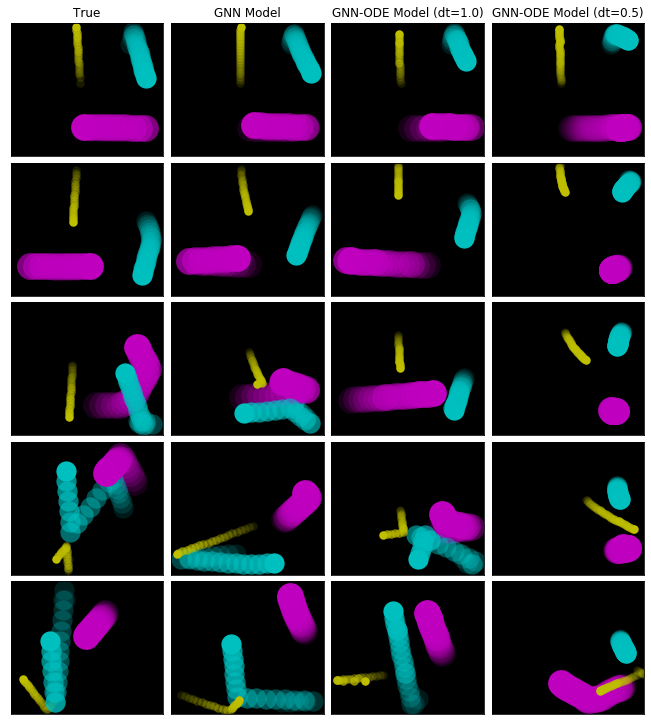

In [32]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

fig, axs = plt.subplots(ncols=4, nrows=5, figsize = (8, 8), sharex='all', sharey='all')
axs[0,0].set_title('True')
axs[0,1].set_title('GNN Model')
axs[0,2].set_title('GNN-ODE Model (dt=1.0)')
axs[0,3].set_title('GNN-ODE Model (dt=0.5)')
fig.tight_layout()
for i in range(0,100,20):
    row = i // 20
    for s in range(0, 20):
        for b in range(0,n_balls):
            alpha = 0.1+((s+1)/30)
            size_mult = (1/np.sqrt(20-s))
            size_mult = 1
            if s == 19:
                alpha = 1
            axs[row,0].set_ylim(0,10)
            axs[row,0].set_xlim(0,10)
            axs[row,0].set_xticks([], [])
            axs[row,0].set_yticks([], [])
            axs[row,0].set_facecolor((0.0, 0.0, 0.0))
            axs[row,0].scatter(x=states[i+s][0][b][0],y=states[i+s][0][b][1],s=testset.radiuses[0][b][0]**2*650*size_mult,alpha=alpha, c=colors[b+3], linewidth='0')
            axs[row,1].set_ylim(0,10)
            axs[row,1].set_xlim(0,10)
            axs[row,1].set_xticks([], [])
            axs[row,1].set_yticks([], [])
            axs[row,1].set_facecolor((0.0, 0.0, 0.0))
            axs[row,1].scatter(x=states[i+s][1][b][0],y=states[i+s][1][b][1],s=testset.radiuses[0][b][0]**2*650*size_mult,alpha=alpha, c=colors[b+3], linewidth='0')
            axs[row,2].set_ylim(0,10)
            axs[row,2].set_xlim(0,10)
            axs[row,2].set_xticks([], [])
            axs[row,2].set_yticks([], [])
            axs[row,2].set_facecolor((0.0, 0.0, 0.0))
            axs[row,2].scatter(x=states[i+s][2][b][0],y=states[i+s][2][b][1],s=testset.radiuses[0][b][0]**2*650*size_mult,alpha=alpha, c=colors[b+3], linewidth='0')
            
for i in range(0,200,40):
    row = i // 40
    for s in range(0, 40):
        for b in range(0,n_balls):
            alpha = 0.1+((s+1)/65)
            size_mult = (1/np.sqrt(40-s))
            size_mult = 1
            if s == 39:
                alpha = 1
            axs[row,3].set_ylim(0,10)
            axs[row,3].set_xlim(0,10)
            axs[row,3].set_xticks([], [])
            axs[row,3].set_yticks([], [])
            axs[row,3].set_facecolor((0.0, 0.0, 0.0))
            axs[row,3].scatter(x=states2[i+s][0][b][0],y=states2[i+s][0][b][1],s=testset.radiuses[0][b][0]**2*650*size_mult,alpha=alpha, c=colors[b+3], linewidth='0')
            
fig.subplots_adjust(wspace=0.05, hspace=0.05, top=1.2, bottom=0, left=0, right=1.1)
plt.savefig("results.pdf", bbox_inches='tight')
plt.show()

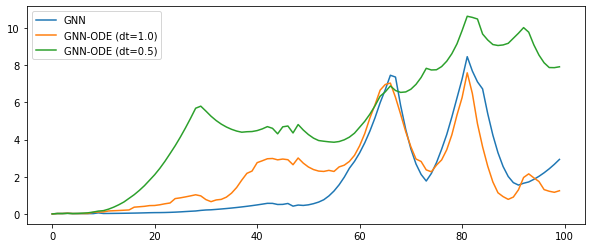

In [62]:
sim_bb_states = states[:,0,:,:]
gnn_bb_states = states[:,1,:,:]
gnn_bb_ode_states = states[:,2,:,:]
gnn_bb_ode_states2 = states2[::2,0,:,:]

mse_gnn_bb = []
mse_gnn_bb_ode = []
mse_gnn_bb_ode2 = []
for i in range(100):
    mse_gnn_bb.append(np.square(np.subtract(sim_bb_states[i], gnn_bb_states[i])).mean())
    mse_gnn_bb_ode.append(np.square(np.subtract(sim_bb_states[i], gnn_bb_ode_states[i])).mean())
    mse_gnn_bb_ode2.append(np.square(np.subtract(sim_bb_states[i], gnn_bb_ode_states2[i])).mean())

fig = plt.figure(figsize=(10,4))
gnn, = plt.plot(mse_gnn_bb)
gnn_ode, = plt.plot(mse_gnn_bb_ode)
gnn_ode2, = plt.plot(mse_gnn_bb_ode2)
plt.legend((gnn, gnn_ode, gnn_ode2), ('GNN', 'GNN-ODE (dt=1.0)', 'GNN-ODE (dt=0.5)'))
plt.savefig("mses.pdf")
plt.show()